In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/creditcard.csv')
display(df.head(), df.describe())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Data Preprocessing

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#### Split Dataset
here we split our dataset for training and testing purposes where the test data will be set a side for our model perfomance evaluation before set to production

In [4]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_set.shape, test_set.shape

((227845, 31), (56962, 31))

In [5]:
display('Train Set', train_set.head(), 'Test Set', test_set.head())

'Train Set'

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
223361,143352.0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
165061,117173.0,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
238186,149565.0,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
150562,93670.0,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
138452,82655.0,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0


'Test Set'

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [6]:
# here we set our predictors variable (X) and our target variables (y)
X = train_set.drop(columns=['Time', 'Class'])
y = train_set['Class']  
X_test = test_set.drop(columns=['Time', 'Class'])
y_test = test_set['Class']  

print(f'X shape {X.shape}, y shape {y.shape} fraud cases {y.sum()} \
    X test shape {X_test.shape}, y test shape {y_test.shape} fraud on test cases {y_test.sum()} ')

X shape (227845, 29), y shape (227845,) fraud cases 394     X test shape (56962, 29), y test shape (56962,) fraud on test cases 98 


<AxesSubplot:xlabel='Class', ylabel='count'>

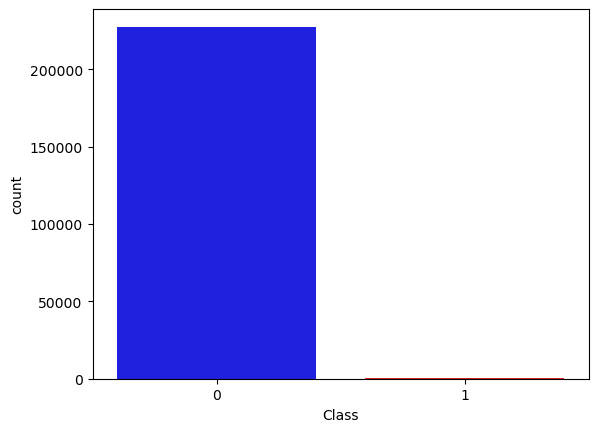

In [7]:
# plot our target variable to view if we have an imbalanced dataset
sn.countplot(x=y, palette=['blue', 'red'])

we have an imbalanced dataset which might cause bias prediction on the majority class which is the non_fraud cases (0), so here we are going to over sample our dataset to keep most of the information,
Note: 
oversampling might cause the model to over fit,a good way to reduce overfitting is to regularize the
model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be
for it to overfit the data.you may need to use a regularization techniques that can reduce the risk of overfitting the training set

<AxesSubplot:xlabel='Class', ylabel='count'>

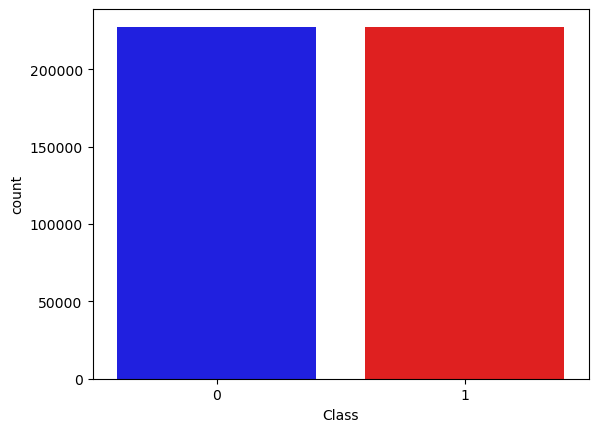

In [8]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)
sn.countplot(x=y, palette=['blue', 'red'])

In [9]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

### Model Evaluation | Selection


In [10]:
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, mean_squared_error

In [11]:
skfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

def heatmap(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    sn.heatmap(cm, annot=True, linewidths=.5, cmap='Blues_r', square=True, fmt='.3f')    
    plt.title(f'F1_score {f1_score(y_test, preds)}')
    plt.ylabel('Predicted Values')
    plt.xlabel('Actual Values')

def threshold():
    pass

def train_model(model, X, y):
    model = clone(model)
    count = 0
    scores = []
    for train_fold, test_fold in skfold.split(X, y):
        count += 1
        print(f'Fold {count} training...')
        X_train_fold, y_train_fold  = X[train_fold], y[train_fold]
        X_test_fold, y_test_fold = X[test_fold], y[test_fold]
        
        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_test_fold)
        scores.append(f1_score(y_test_fold, preds))
        print(f'Score {f1_score(y_test_fold, preds)}')
    print(f'Mean Score {np.mean(scores)}')
    
    return model
    
    
# train and plot learning perfomance
def train_evaluate(model, X, y):
    count = 0
    train_score , test_score =[], []
    
    for train_fold, test_fold in skfold.split(X, y):
        count += 1
        print(f'Fold {count} training...')
        X_train_fold, y_train_fold  = X[train_fold], y[train_fold]
        X_test_fold, y_test_fold = X[test_fold], y[test_fold]
        
        model.fit(X_train_fold, y_train_fold)
        
        train_pred = model.predict(X_train_fold)
        test_pred = model.predict(X_test_fold)
        
        train_score.append(mean_squared_error(y_train_fold, train_pred))
        test_score.append(mean_squared_error(y_test_fold, test_pred))
        
        print(f"F1_score Train {f1_score(y_train_fold, train_pred)} MSE Train {mean_squared_error(y_train_fold, train_pred)}")
        print(f"F1_score Test {f1_score(y_test_fold, test_pred)} MSE Test {mean_squared_error(y_test_fold, test_pred)}")
        
    plt.plot(np.sqrt(train_score), "r-.", linewidth=2, label="train")
    plt.plot(np.sqrt(test_score), "b-", linewidth=2, label="test")
    plt.title('Learning Curve')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Training Fold | Size')
    plt.legend()
    plt.show()


##### HistGradientBoostingClasifier Algorithim

Fold 1 training...
F1_score Train 0.9999874386061877 MSE Train 1.2561583161449003e-05
F1_score Test 0.9999648283624085 MSE Test 3.51722561243691e-05
Fold 2 training...
F1_score Train 0.9999949754046055 MSE Train 5.0246332645796015e-06
F1_score Test 0.9998944925089681 MSE Test 0.0001055167683731073
Fold 3 training...
F1_score Train 0.9999899508597039 MSE Train 1.0049266529159203e-05
F1_score Test 0.9999120755446921 MSE Test 8.793064031092274e-05
Fold 4 training...
F1_score Train 0.9999924630879734 MSE Train 7.536949896869403e-06
F1_score Test 0.9999120786368672 MSE Test 8.793064031092274e-05
Fold 5 training...
F1_score Train 0.9999949753793588 MSE Train 5.0246332645796015e-06
F1_score Test 0.9999472453268152 MSE Test 5.275838418655365e-05
Fold 6 training...
F1_score Train 0.9999924630879734 MSE Train 7.536949896869403e-06
F1_score Test 0.9999824144904599 MSE Test 1.758612806218455e-05
Fold 7 training...
F1_score Train 0.9999799019213763 MSE Train 2.0098482564566377e-05
F1_score Test 0.9

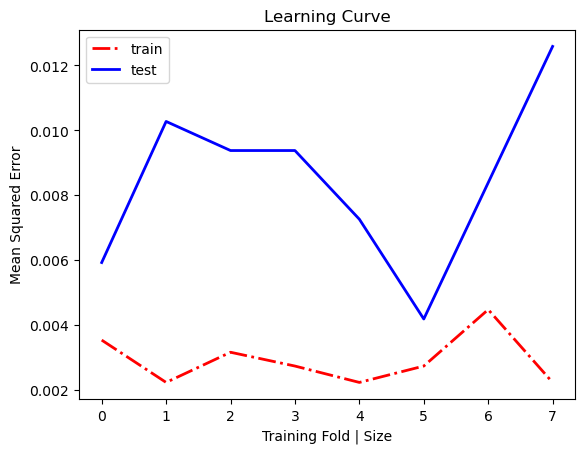

In [12]:
gbc=HistGradientBoostingClassifier(max_iter=1000, random_state=42)
train_evaluate(gbc, X, y)


##### RandomForestClassifier Algorithim

Fold 1 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999824138719378 MSE Test 1.758612806218455e-05
Fold 2 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999296591988183 MSE Test 7.03445122487382e-05
Fold 3 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999120755446921 MSE Test 8.793064031092274e-05
Fold 4 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999472453268152 MSE Test 5.275838418655365e-05
Fold 5 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999824144904599 MSE Test 1.758612806218455e-05
Fold 6 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 1.0 MSE Test 0.0
Fold 7 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999648283624085 MSE Test 3.5172874679047515e-05
Fold 8 training...
F1_score Train 1.0 MSE Train 0.0
F1_score Test 0.9999296591988183 MSE Test 7.034574935809503e-05


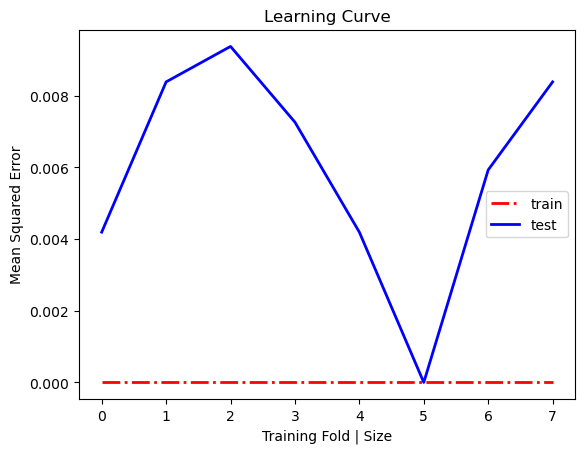

In [13]:
rfc = RandomForestClassifier()
train_evaluate(rfc, X, y)

##### Nueral Network

Fold 1 training...
F1_score Train 0.9998492840994725 MSE Train 0.00015073899793738803
F1_score Test 0.99973627301018 MSE Test 0.00026379192093276823
Fold 2 training...
F1_score Train 0.9998744002612475 MSE Train 0.00012561583161449004
F1_score Test 0.9997186961566863 MSE Test 0.0002813780489949528
Fold 3 training...
F1_score Train 0.9998442610185329 MSE Train 0.00015576363120196765
F1_score Test 0.9996308211592215 MSE Test 0.0003693086893058755
Fold 4 training...
F1_score Train 0.9998970053682812 MSE Train 0.00010300498192388184
F1_score Test 0.9996835554305404 MSE Test 0.00031655030511932187
Fold 5 training...
F1_score Train 0.9998869582474007 MSE Train 0.00011305424845304104
F1_score Test 0.9995956897006345 MSE Test 0.00040448094543024465
Fold 6 training...
F1_score Train 0.9998970053682812 MSE Train 0.00010300498192388184
F1_score Test 0.9995956897006345 MSE Test 0.00040448094543024465
Fold 7 training...
F1_score Train 0.9999020294966576 MSE Train 9.798010250226108e-05
F1_score Test

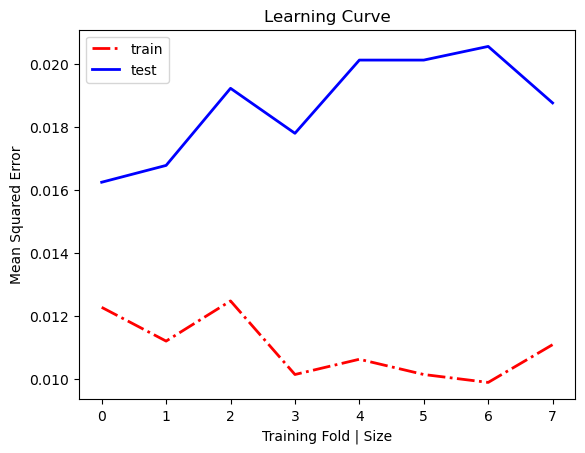

In [14]:
mlpc = MLPClassifier()
train_evaluate(mlpc, X, y)

##### Regularization
After evaluating our models seem to be overfitting on the train set with more errors on test set, we had an imbalanced target dataset which we oversampled using imlearn package oversampling introduces overfitting, and a good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be
for it to overfit the data.

Fold 1 training...
F1_score Train 0.9567403848664455 MSE Train 0.041624061963777416
F1_score Test 0.9584427904261529 MSE Test 0.0400611997256564
Fold 2 training...
F1_score Train 0.9560489565353836 MSE Train 0.04222199332226239
F1_score Test 0.9565185578136719 MSE Test 0.041802226403812676
Fold 3 training...
F1_score Train 0.956103452693111 MSE Train 0.042184308572778044
F1_score Test 0.9549734383586738 MSE Test 0.04322670277684962
Fold 4 training...
F1_score Train 0.9574473085651164 MSE Train 0.04093819952316231
F1_score Test 0.957086175056225 MSE Test 0.041274642561947135
Fold 5 training...
F1_score Train 0.9547811331426956 MSE Train 0.04338268360638028
F1_score Test 0.9550028409611613 MSE Test 0.04317394439266307
Fold 6 training...
F1_score Train 0.9561323011521841 MSE Train 0.04215416077319057
F1_score Test 0.9549559451191588 MSE Test 0.043244288904911804
Fold 7 training...
F1_score Train 0.9587418130240707 MSE Train 0.03975479851271229
F1_score Test 0.9574930983417737 MSE Test 0.0

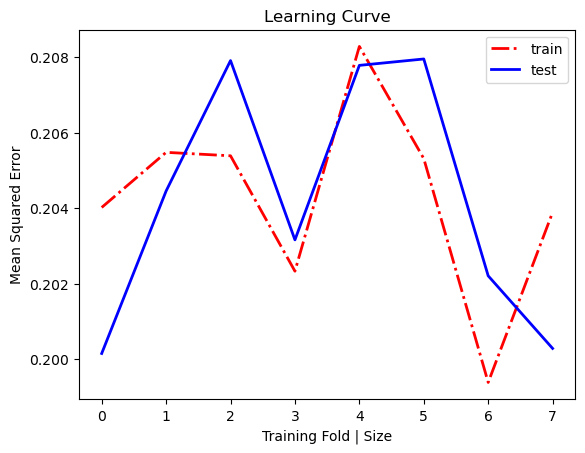

In [15]:
# by setting a lower max_depth parameter on random forest classifier we reduce the chances of over fitting
rfc = RandomForestClassifier(max_depth=5)
train_evaluate(rfc, X, y)

Test model perfomance with unseen data this is the data set that the model never saw during training and evaluation. In our case its the test set that we splited in the beginning

Fold 1 training...
Score 0.9592502780462012
Fold 2 training...
Score 0.9590235714806977
Fold 3 training...
Score 0.9551047312142962
Fold 4 training...
Score 0.9554359368706289
Fold 5 training...
Score 0.9560363130536643
Fold 6 training...
Score 0.9575786376181165
Fold 7 training...
Score 0.9535412844036698
Fold 8 training...
Score 0.956990820319643
Mean Score 0.9566201966258647


(243, 98)

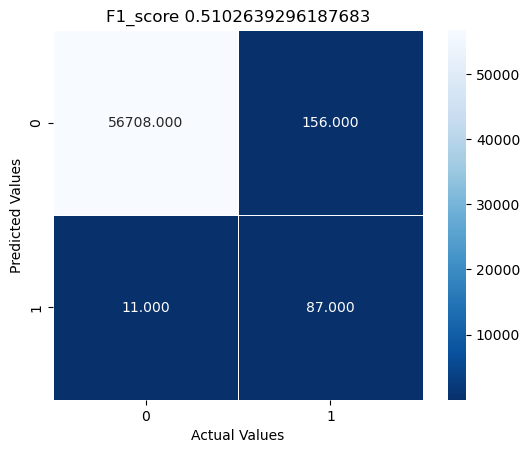

In [16]:
model = train_model(rfc, X, y)
prediction = model.predict(X_test)
heatmap(y_test, prediction)

from our heat map above we have a high number of false positives (i.e., classify as fraud when it's not) here we are going to use a threshold to reduce the number of false positives while still catching most fraud cases"

In [20]:
pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_threshold = np.where(pred_prob > 0.8, 1, 0)
y_pred_threshold.sum()

94

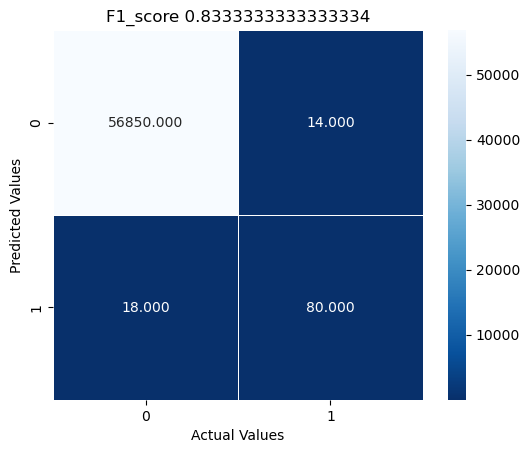

In [21]:
heatmap(y_test, y_pred_threshold)